# Modeling the grade

In [1]:
# %load_ext lab_black


In [1]:
%reload_ext autoreload
%autoreload 1
import sklearn

sklearn.set_config(transform_output="pandas")
import category_encoders as ce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as myFunc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import functions as myFunc
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn import set_config
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    classification_report,
)
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.metrics import f1_score
import shap
from joblib import dump

c:\Users\jonyt\anaconda3\envs\conda_ds_39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
set_config(display="diagram")

# Accepted data

In [4]:
accepted_loan_df = pd.read_csv(
    "accepted_2007_to_2018Q4.csv", header=0, skiprows=lambda i: i % 2 != 0
)

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


## Data transformation

In [5]:
cleaned_df_accepted = (
    accepted_loan_df.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        [
            "issue_d",
        ],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(
        myFunc.months_sin_cos,
        [
            "Month_issue_d",
        ],
    )
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(myFunc.calc_risk, "sec_app_fico_range_low", "sec_app_fico_range_high")
    .pipe(myFunc.calc_risk, "last_fico_range_low", "last_fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "addr_state",
            "policy_code",
            "Month_issue_d",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "hardship_reason",
        ],
    )
    .pipe(myFunc.drop_rows_if_nan, "grade")
    .pipe(myFunc.drop_rows_if_nan, "sub_grade")
    .pipe(myFunc.drop_rows_if_nan, "int_rate")
)

In [6]:
cleaned_df_accepted.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_status,deferral_term,hardship_amount,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,Year_issue_d,cos_Month_issue_d,sin_Month_issue_d,log_loan_amnt,risk_score
0,24700.00,24700.00,24700.00,36.00,11.99,820.28,C,C1,10.00,MORTGAGE,65000.00,Not Verified,Fully Paid,n,16.06,1.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,926.35,0.00,NaN,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,5.00,13.00,17.00,6.00,20.00,27.00,5.00,22.00,0.00,0.00,0.00,2.00,97.40,7.70,0.00,0.00,314017.00,39475.00,79300.00,24667.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,2015.00,1.00,-0.00,10.11,697.00
1,35000.00,35000.00,35000.00,60.00,14.85,829.90,C,C5,10.00,MORTGAGE,110000.00,Source Verified,Current,n,17.06,0.00,0.00,NaN,NaN,13.00,0.00,7802.00,11.60,17.00,w,15897.65,15897.65,31464.01,31464.01,19102.35,12361.66,0.00,0.00,0.00,829.90,0.00,NaN,Individual,NaN,NaN,NaN,0.00,0.00,301500.00,1.00,1.00,0.00,1.00,23.00,12609.00,70.00,1.00,1.00,6987.00,45.00,67300.00,0.00,1.00,0.00,2.00,23192.00,54962.00,12.10,0.00,0.00,36.00,87.00,2.00,2.00,1.00,2.00,NaN,NaN,NaN,0.00,4.00,5.00,8.00,10.00,2.00,10.00,13.00,5.00,13.00,0.00,0.00,0.00,1.00,100.00,0.00,0.00,0.00,381215.00,52226.00,62500.00,18000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,2015.00,1.00,-0.00,10.46,677.00
2,11950.00,11950.00,11950.00,36.00,13.44,405.18,C,C3,4.00,RENT,34000.00,Source Verified,Fully Paid,n,10.20,0.00,0.00,NaN,NaN,5.00,0.00,8822.00,68.40,6.00,w,0.00,0.00,13708.95,13708.95,11950.00,1758.95,0.00,0.00,0.00,7653.56,0.00,NaN,Individual,NaN,NaN,NaN,0.00,0.00,12798.00,0.00,1.00,0.00,0.00,338.00,3976.00,99.00,0.00,0.00,4522.00,76.00,12900.00,0.00,0.00,0.00,0.00,2560.00,844.00,91.00,0.00,0.00,338.00,54.00,32.00,32.00,0.00,36.00,NaN,NaN,NaN,0.00,2.00,

From EDA we saw, that sub_grade and int_rate are correlated, so we should drop it from out model dataset.

In [7]:
cleaned_df_accepted = cleaned_df_accepted.drop(["sub_grade", "int_rate"], axis=1)

## Encoding target variable

In [8]:
label_encoder = preprocessing.LabelEncoder()
cleaned_df_accepted["grade"] = label_encoder.fit_transform(cleaned_df_accepted["grade"])
cleaned_df_accepted["grade"].unique()

array([2, 1, 4, 0, 3, 5, 6])

## Spliting into train, test and validation sets

In [9]:
df_train, df_test_val = train_test_split(
    cleaned_df_accepted,
    test_size=0.2,
    random_state=3,
    stratify=cleaned_df_accepted["grade"],
)

Now, we can release RAM memory

In [10]:
lst = [cleaned_df_accepted]
del [cleaned_df_accepted]
del lst

In [11]:
df_test, df_val = train_test_split(
    df_test_val, test_size=0.5, random_state=6, stratify=df_test_val["grade"]
)

## Balancing the training dataframe

In [12]:
print(Counter(df_train.grade))

Counter({1: 265473, 2: 260020, 0: 173295, 3: 129666, 4: 54354, 5: 16564, 6: 4894})


We may see, that our classes are imbalansed, so we will need to balance it according to the smallest class amount.

In [13]:
grouped_classes = df_train.groupby("grade", group_keys=False)
df_train = pd.DataFrame(
    grouped_classes.apply(lambda x: x.sample(grouped_classes.size().min()))
).reset_index(drop=True)

In [14]:
print(Counter(df_train.grade))

Counter({0: 4894, 1: 4894, 2: 4894, 3: 4894, 4: 4894, 5: 4894, 6: 4894})


Final data sets for modeling

In [15]:
X_train = df_train.drop(["grade"], axis=1)
y_train = df_train["grade"]
X_test = df_test.drop(["grade"], axis=1)
y_test = df_test["grade"]
X_val = df_val.drop(["grade"], axis=1)
y_val = df_val["grade"]

In [16]:
X_train.shape, X_test.shape, X_val.shape

((34258, 125), (113033, 125), (113034, 125))

In [17]:
y_train.shape, y_test.shape, y_val.shape

((34258,), (113033,), (113034,))

Let's check if our target is balanced.

In [18]:
y_train.value_counts()

grade
0    4894
1    4894
2    4894
3    4894
4    4894
5    4894
6    4894
Name: count, dtype: int64

In [19]:
y_test.value_counts()

grade
1    33184
2    32502
0    21662
3    16208
4     6794
5     2071
6      612
Name: count, dtype: int64

In [20]:
y_val.value_counts()

grade
1    33185
2    32503
0    21662
3    16209
4     6794
5     2070
6      611
Name: count, dtype: int64

Realease RAM mermory:

In [21]:
lst = [df_train, df_test_val]
del [df_train, df_test_val]
del lst

## Columns selection

In [22]:
numeric_cols2 = X_train.select_dtypes(include=np.number).columns.to_list()

In [23]:
dummy_cols = list(set(X_train.columns) - set(numeric_cols2))

In [24]:
categorical_transformer = Pipeline(
    [
        (
            "rare_categorical_replace",
            ColumnTransformer(
                [
                    (
                        "rare_cat_replace",
                        FunctionTransformer(
                            myFunc.replace_rare_categorical_values, validate=False
                        ),
                        dummy_cols,
                    ),
                ]
            ),
        ),
        (
            "imputer",
            SimpleImputer(
                missing_values=np.nan,
                strategy="constant",
                fill_value="-9999",
            ),
        ),
        ("onehot_encoder", ce.OneHotEncoder()),
    ]
)

In [25]:
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        )
    ]
)

In [26]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ("numeric_transformer", numeric_transformer, numeric_cols2),
        ("onehot", categorical_transformer, dummy_cols),
    ],
    remainder="passthrough",
)

# Extracting most important features

In [27]:
pipeline_for_features = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
    ]
)

In [28]:
X_train_transformed = pipeline_for_features.fit_transform(X_train)

To extract most omportant features, we will use random forest feature_importances_ parameter. But first, let's train the Random Forest model.

In [29]:
model = RandomForestClassifier(n_estimators=50).fit(X_train_transformed, y_train)

<BarContainer object of 152 artists>

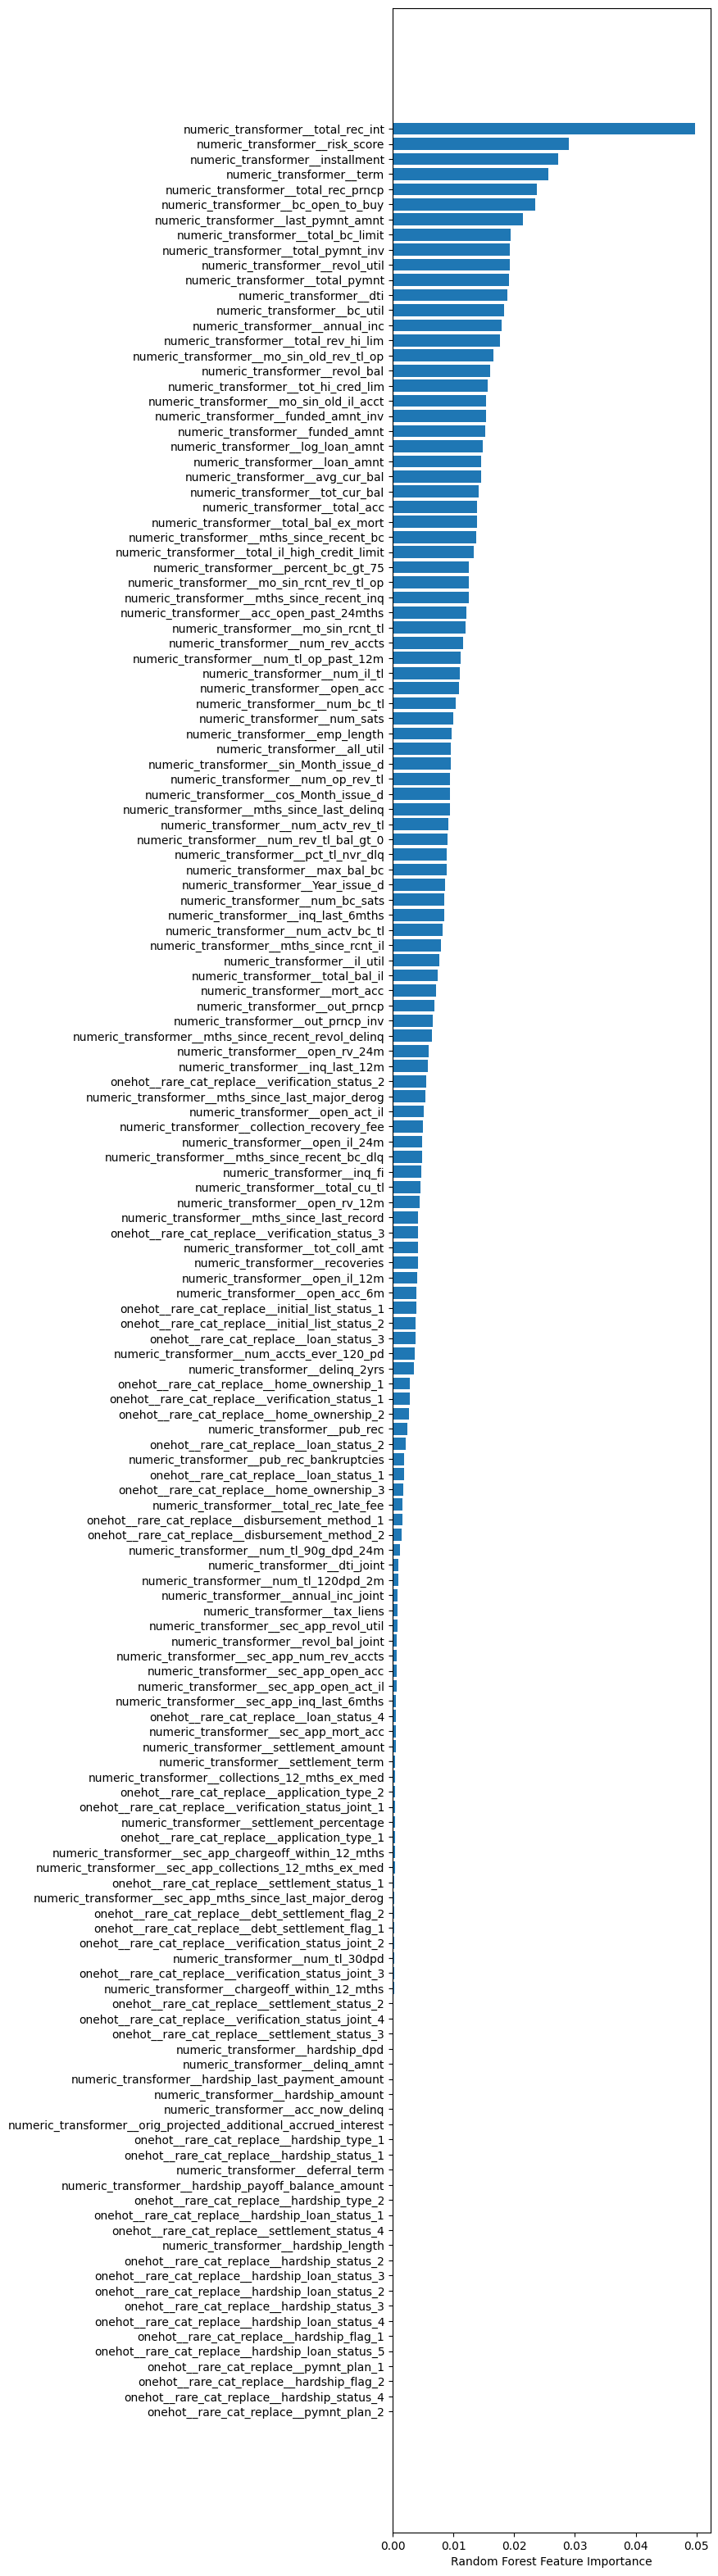

In [30]:
plt.figure(figsize=(5, 40))
plt.xlabel("Random Forest Feature Importance")
sorted_idx = model.feature_importances_.argsort()
plt.barh(
    X_train_transformed.columns[sorted_idx], model.feature_importances_[sorted_idx]
)

In [31]:
feat_importances = pd.DataFrame(
    data=model.feature_importances_, index=X_train_transformed.columns
)
leave_df_grade = feat_importances[feat_importances[0] > 0.001]
leave_df_grade.sort_values(by=0, ascending=False)

,0
numeric_transformer__total_rec_int,0.05
numeric_transformer__risk_score,0.03
numeric_transformer__installment,0.03
numeric_transformer__term,0.03
numeric_transformer__total_rec_prncp,0.02
numeric_transformer__bc_open_to_buy,0.02
numeric_transformer__last_pymnt_amnt,0.02
numeric_transformer__total_bc_limit,0.02
numeric_transformer__total_pymnt_inv,0.02
numeric_transformer__revol_util,0.02


In [32]:
important_feature_list_for_grade = leave_df_grade.index.to_list()
len(important_feature_list_for_grade)

95

In [33]:
features_to_drop = list(
    set(feat_importances.index.to_list()) - set(leave_df_grade.index.to_list())
)
len(features_to_drop)

57

In [34]:
lst = [X_train_transformed]
del [X_train_transformed]
del lst

Result from this part is that we managed to get a list of not important features, wich we can drop from dataset. In next chapter we will make final pipeline for modeling.

# Making a final pipeline

Now, as we know wich features are not important, let's create final data transformation pipeline.

In [3]:
accepted_loan_df1 = pd.read_csv(
    "accepted_2007_to_2018Q4.csv", header=0, skiprows=range(1, 1000000)
)

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
accepted_loan_df1.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,75275669,NaN,25000.00,25000.00,25000.00,60 months,8.39,511.59,B,B1,Security,2 years,MORTGAGE,65000.00,Not Verified,Mar-2016,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,411xx,KY,27.07,0.00,Feb-1992,720.00,724.00,0.00,NaN,NaN,17.00,0.00,31596.00,39.80,37.00,w,12968.51,12968.51,16347.57,16347.57,12031.49,4316.08,0.00,0.00,0.00,Dec-2018,511.59,Apr-2019,Mar-2019,539.00,535.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,163366.00,0.00,3.00,0.00,1.00,23.00,30190.00,69.00,2.00,2.00,15032.00,50.00,79400.00,0.00,9.00,0.00,4.00,9610.00,32944.00,40.60,0.00,0.00,276.00,289.00,10.00,10.00,2.00,10.00,NaN,23.00,NaN,0.00,6.00,8.00,9.00,10.00,15.00,13.00,20.00,8.00,17.00,0.00,0.00,0.00,2.00,100.00,22.20,0.00,0.00,231323.00,61786.00,55500.00,43814.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,75184391,NaN,7400.00,7400.00,7400.00,36 months,16.29,261.23,D,D1,Manager,10+ years,RENT,65000.00,Not Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,vacation,Vacation,926xx,CA,22.99,2.00,Aug-2004,675.00,679.00,1.00,4.00,NaN,9.00,0.00,1314.00,36.50,25.00,w,0.00,0.00,9390.56,9390.56,7400.00,1990.56,0.00,0.00,0.00,Mar-2019,260.90,NaN,Mar-2019,664.00,660.00,0.00,14.00,1.00,Individual,NaN,NaN,NaN,0.00,0.00,102394.00,1.00,6.00,0.00,2.00,13.00,101080.00,145.00,1.00,1.00,486.00,140.00,3600.00,1.00,0.00,1.00,3.00,11377.00,2286.00,36.50,0.00,0.00,139.00,110.00,4.00,4.00,0.00,4.00,NaN,4.

In [5]:
accepted_loan_df1.shape

(1260702, 151)

In [6]:
cleaned_df_accepted1 = (
    accepted_loan_df1.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        [
            "issue_d",
        ],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(
        myFunc.months_sin_cos,
        [
            "Month_issue_d",
        ],
    )
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(myFunc.calc_risk, "sec_app_fico_range_low", "sec_app_fico_range_high")
    .pipe(myFunc.calc_risk, "last_fico_range_low", "last_fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "addr_state",
            "policy_code",
            "Month_issue_d",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "revol_bal_joint",
            "tax_liens",
            "sec_app_num_rev_accts",
            "sec_app_mths_since_last_major_derog",
            "orig_projected_additional_accrued_interest",
            "num_tl_120dpd_2m",
            "hardship_amount",
            "settlement_term",
            "sec_app_chargeoff_within_12_mths",
            "collections_12_mths_ex_med",
            "hardship_payoff_balance_amount",
            "hardship_length",
            "delinq_amnt",
            "sec_app_open_act_il",
            "sec_app_inq_last_6mths",
            "chargeoff_within_12_mths",
            "settlement_amount",
            "hardship_dpd",
            "num_tl_30dpd",
            "acc_now_delinq",
            "settlement_percentage",
            "dti_joint",
            "sec_app_collections_12_mths_ex_med",
            "sec_app_open_acc",
            "sec_app_mort_acc",
            "sec_app_revol_util",
            "annual_inc_joint",
            "deferral_term",
            "hardship_last_payment_amount",
            "hardship_status",
            "hardship_type",
            "verification_status",
            "settlement_status",
            "hardship_loan_status",
            "hardship_flag",
            "pymnt_plan",
            "application_type",
            "debt_settlement_flag",
            "loan_status",
            "hardship_reason",
        ],
    )
    .pipe(myFunc.drop_rows_if_nan, "grade")
    .pipe(myFunc.drop_rows_if_nan, "sub_grade")
    .pipe(myFunc.drop_rows_if_nan, "int_rate")
    .pipe(
        myFunc.drop_columns,
        [
            "sub_grade",
            "int_rate",
        ],
    )
)


In [7]:
cleaned_df_accepted1.shape

(1260681, 87)

Extraction of the second bach of data:

In [8]:
accepted_loan_df2 = pd.read_csv("accepted_2007_to_2018Q4.csv", nrows=1000000)

Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


In [9]:
accepted_loan_df2.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,Mar-2019,564.00,560.00,0.00,30.00,1.00,Individual,NaN,NaN,NaN,0.00,722.00,144904.00,2.00,2.00,0.00,1.00,21.00,4981.00,36.00,3.00,3.00,722.00,34.00,9300.00,3.00,1.00,4.00,4.00,20701.00,1506.00,37.20,0.00,0.00,148.00,128.00,3.00,3.00,1.00,4.00,69.00,4.00,69.00,2.00,2.00,4.00,2.00,5.00,3.00,4.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,Mar-2019,699.00,695.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,

In [10]:
cleaned_df_accepted2 = (
    accepted_loan_df2.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        ["issue_d"],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(
        myFunc.months_sin_cos,
        [
            "Month_issue_d",
        ],
    )
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(myFunc.calc_risk, "sec_app_fico_range_low", "sec_app_fico_range_high")
    .pipe(myFunc.calc_risk, "last_fico_range_low", "last_fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "addr_state",
            "policy_code",
            "Month_issue_d",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "revol_bal_joint",
            "tax_liens",
            "sec_app_num_rev_accts",
            "sec_app_mths_since_last_major_derog",
            "orig_projected_additional_accrued_interest",
            "num_tl_120dpd_2m",
            "hardship_amount",
            "settlement_term",
            "sec_app_chargeoff_within_12_mths",
            "collections_12_mths_ex_med",
            "hardship_payoff_balance_amount",
            "hardship_length",
            "delinq_amnt",
            "sec_app_open_act_il",
            "sec_app_inq_last_6mths",
            "chargeoff_within_12_mths",
            "settlement_amount",
            "hardship_dpd",
            "num_tl_30dpd",
            "acc_now_delinq",
            "settlement_percentage",
            "dti_joint",
            "sec_app_collections_12_mths_ex_med",
            "sec_app_open_acc",
            "sec_app_mort_acc",
            "sec_app_revol_util",
            "annual_inc_joint",
            "deferral_term",
            "hardship_last_payment_amount",
            "hardship_status",
            "hardship_type",
            "verification_status",
            "settlement_status",
            "hardship_loan_status",
            "hardship_flag",
            "pymnt_plan",
            "application_type",
            "debt_settlement_flag",
            "loan_status",
            "hardship_reason",
        ],
    )
    .pipe(myFunc.drop_rows_if_nan, "grade")
    .pipe(myFunc.drop_rows_if_nan, "sub_grade")
    .pipe(myFunc.drop_rows_if_nan, "int_rate")
    .pipe(
        myFunc.drop_columns,
        [
            "sub_grade",
            "int_rate",
        ],
    )
)


Let's concatinate two parts of data.

In [11]:
cleaned_df_accepted = pd.concat([cleaned_df_accepted1, cleaned_df_accepted2])

In [12]:
lst = [cleaned_df_accepted2, cleaned_df_accepted1]
del [cleaned_df_accepted2, cleaned_df_accepted1]
del lst

In [13]:
cleaned_df_accepted.shape

(2260669, 87)

Just to be sure, let's check for duplibates and drop if any.

In [14]:
cleaned_df_accepted = cleaned_df_accepted.drop_duplicates()
cleaned_df_accepted.shape

(2260668, 87)

# Modeling of the grades using just most important features

First, we need to encode our target.

In [15]:
label_encoder = preprocessing.LabelEncoder()
cleaned_df_accepted["grade"] = label_encoder.fit_transform(cleaned_df_accepted["grade"])
cleaned_df_accepted["grade"].unique()

array([1, 3, 2, 4, 0, 5, 6])

## Spliting into train, test and validation sets

In [16]:
df_train, df_test_val = train_test_split(
    cleaned_df_accepted,
    test_size=0.2,
    random_state=3,
    stratify=cleaned_df_accepted["grade"],
)

Now, we can release RAM memory

In [17]:
lst = [cleaned_df_accepted]
del [cleaned_df_accepted]
del lst

In [18]:
df_test, df_val = train_test_split(
    df_test_val, test_size=0.5, random_state=6, stratify=df_test_val["grade"]
)

## Balancing the training dataframe

In [19]:
print(Counter(df_train.grade))

Counter({1: 530846, 2: 520042, 0: 346422, 3: 259539, 4: 108511, 5: 33440, 6: 9734})


We may see, that our classes are imbalansed, so we will need to balance it according to the smallest class amount.

In [20]:
grouped_classes = df_train.groupby("grade", group_keys=False)
df_train = pd.DataFrame(
    grouped_classes.apply(lambda x: x.sample(grouped_classes.size().min()))
).reset_index(drop=True)

In [21]:
print(Counter(df_train.grade))

Counter({0: 9734, 1: 9734, 2: 9734, 3: 9734, 4: 9734, 5: 9734, 6: 9734})


Final data sets for modeling

In [22]:
X_train = df_train.drop(["grade"], axis=1)
y_train = df_train["grade"]
X_test = df_test.drop(["grade"], axis=1)
y_test = df_test["grade"]
X_val = df_val.drop(["grade"], axis=1)
y_val = df_val["grade"]

In [23]:
X_train.shape, X_test.shape, X_val.shape

((68138, 86), (226067, 86), (226067, 86))

In [24]:
y_train.shape, y_test.shape, y_val.shape

((68138,), (226067,), (226067,))

Let's check if our target is balanced.

In [25]:
y_train.value_counts()

grade
0    9734
1    9734
2    9734
3    9734
4    9734
5    9734
6    9734
Name: count, dtype: int64

In [26]:
y_test.value_counts()

grade
1    66356
2    65005
0    43303
3    32442
4    13564
5     4180
6     1217
Name: count, dtype: int64

In [27]:
y_val.value_counts()

grade
1    66355
2    65006
0    43302
3    32443
4    13564
5     4180
6     1217
Name: count, dtype: int64

Realease RAM mermory:

In [28]:
lst = [df_train, df_test_val]
del [df_train, df_test_val]
del lst

## Columns selection

In [29]:
numeric_cols2 = X_train.select_dtypes(include=np.number).columns.to_list()

In [30]:
len(numeric_cols2)

82

In [31]:
dummy_cols = list(set(X_train.columns) - set(numeric_cols2))

In [32]:
dummy_cols

['initial_list_status',
 'verification_status_joint',
 'home_ownership',
 'disbursement_method']

In [33]:
categorical_transformer = Pipeline(
    [
        (
            "rare_categorical_replace",
            ColumnTransformer(
                [
                    (
                        "rare_cat_replace",
                        FunctionTransformer(
                            myFunc.replace_rare_categorical_values, validate=False
                        ),
                        dummy_cols,
                    ),
                ]
            ),
        ),
        (
            "imputer",
            SimpleImputer(
                missing_values=np.nan,
                strategy="constant",
                fill_value="-9999",
            ),
        ),
        ("onehot_encoder", ce.OneHotEncoder()),
    ]
)

In [34]:
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        )
    ]
)

In [35]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ("numeric_transformer", numeric_transformer, numeric_cols2),
        ("onehot", categorical_transformer, dummy_cols),
    ],
    remainder="passthrough",
)

Then our full pipeline looks like this:

In [36]:
final_pipeline = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        # ("printer2", myFunc.PrinterTransformer()),
    ]
)

### Base models

In [37]:
balanced_accuracy = []
accuracy = []
recall = []
precision = []
f1_scores = []
fit_time = []
kfold = StratifiedKFold(n_splits=3)
classifiers = [
    "XGB classifier",
    "LGBM classifier",
    "AdaBoostClassifier",
    "RandomForest",
]


models = [
    XGBClassifier(objective="multi:softmax"),
    LGBMClassifier(objective="multiclass"),
    AdaBoostClassifier(n_estimators=50, random_state=0),
    RandomForestClassifier(n_estimators=50, random_state=0),
]


for model in models:
    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            ("classifier", model),
        ]
    )
    result = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=kfold,
        scoring=(
            "balanced_accuracy",
            "accuracy",
            "f1_macro",
            "recall_macro",
            "precision_macro",
        ),
    )
    fit_time.append(result["fit_time"].mean())
    balanced_accuracy.append(result["test_balanced_accuracy"].mean())
    accuracy.append(result["test_accuracy"].mean())
    recall.append(result["test_recall_macro"].mean())
    precision.append(result["test_precision_macro"].mean())
    f1_scores.append(result["test_f1_macro"].mean())

base_models = pd.DataFrame(
    {
        "Balanced accuracy": balanced_accuracy,
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "f1": f1_scores,
        "Fit_time": fit_time,
    },
    index=classifiers,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11279
[LightGBM] [Info] Number of data points in the train set: 45425, number of used features: 93
[LightGBM] [Info] Start training from score -1.945954
[LightGBM] [Info] Start training from score -1.945954
[LightGBM] [Info] Start training from score -1.945800
[LightGBM] [Info] Start training from score -1.945954
[LightGBM] [Info] Start training from score -1.945954
[LightGBM] [Info] Start training from score -1.945800
[LightGBM] [Info] Start training from score -1.945954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11302
[LightGBM] [Info] Number of data points in the train set: 45425, number of used features: 93
[LightGBM] [Info] Start training from scor

In [39]:
base_models

,Balanced accuracy,Accuracy,Recall,Precision,f1,Fit_time
XGB classifier,0.73,0.73,0.73,0.73,0.73,11.50
LGBM classifier,0.71,0.71,0.71,0.71,0.71,9.10
AdaBoostClassifier,0.39,0.39,0.39,0.39,0.39,17.48
RandomForest,0.49,0.49,0.49,0.48,0.48,26.78


We may see, that XGB classifier and LGBM classifier shows the best results and also are fastest to train. Thease models will be tuned in upcomming chapters. Also, I will add Random forest for further tuning. 

## Random forest hyperparameters tuning

In [ ]:
def objective_rf(trial):
    """Suggests values for hyperparameters, fits model and makes predictions and calculates f1 score"""

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            (
                "classifier",
                RandomForestClassifier(**params),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    metric = f1_score(y_val, y_pred, average="macro")
    return metric

In [ ]:
study_rf = optuna.create_study(direction="maximize")
func_rf = lambda trial: objective_rf(trial)
study_rf.optimize(func_rf, n_trials=20)

[I 2023-10-19 23:13:23,351] A new study created in memory with name: no-name-a8c86775-049a-462a-8aec-49c44e8d82f2


[I 2023-10-19 23:13:28,962] Trial 0 finished with value: 0.23809460044869502 and parameters: {'n_estimators': 14, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.23809460044869502.
[I 2023-10-19 23:13:37,900] Trial 1 finished with value: 0.2728062346026415 and parameters: {'n_estimators': 32, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.2728062346026415.
[I 2023-10-19 23:14:17,301] Trial 2 finished with value: 0.42339973553652727 and parameters: {'n_estimators': 52, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.42339973553652727.
[I 2023-10-19 23:14:26,240] Trial 3 finished with value: 0.36985954497123463 and parameters: {'n_estimators': 13, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.42339973553652727.
[I 2023-10-19 23:16:31,542] Trial 4 finished with value: 0.43105265239540863 and parameters:

In [ ]:
print("Number of finished trials: {}".format(len(study_rf.trials)))
print("Best trial:")
trial_rf_best = study_rf.best_trial

print("  Value: {}".format(trial_rf_best.value))
print("  Params: ")

for key, value in trial_rf_best.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.44898891966040116
  Params: 
    n_estimators: 134
    max_depth: 27
    min_samples_split: 8
    min_samples_leaf: 4



Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.64      0.82      0.72     43302
           1       0.58      0.56      0.57     66355
           2       0.62      0.46      0.53     65006
           3       0.49      0.41      0.44     32443
           4       0.30      0.36      0.33     13564
           5       0.22      0.43      0.29      4180
           6       0.13      0.68      0.22      1217

    accuracy                           0.55    226067
   macro avg       0.42      0.53      0.44    226067
weighted avg       0.56      0.55      0.55    226067



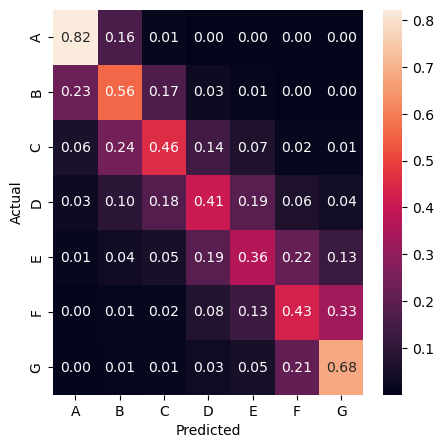

In [ ]:
params_best_rf = trial_rf_best.params

pipeline_rf = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        (
            "classifier",
            RandomForestClassifier(**params_best_rf),
        ),
    ]
)
model_tuned_rf = pipeline_rf.fit(X_train, y_train)
y_pred_vv = model_tuned_rf.predict(X_val)
print("\nClassification Report for Random Forest")
print(classification_report(y_val, y_pred_vv))
myFunc.confusion_matrix_normalized(
    y_val, y_pred_vv, ["A", "B", "C", "D", "E", "F", "G"]
)

## LGBM hyperparameters tuning

In [40]:
def objective_lgbm(trial):
    """Suggests values for hyperparameters, fits model and makes predictions and calculates f1 score"""

    params = {
        "num_boost_round": trial.suggest_int("num_boost_round", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "verbose": -1,
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            (
                "classifier",
                LGBMClassifier(**params, objective="multiclass", force_col_wise=True),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    metric = f1_score(y_val, y_pred, average="macro")
    return metric

In [41]:
study_lgbm = optuna.create_study(direction="maximize")
func_lgbm = lambda trial: objective_lgbm(trial)
study_lgbm.optimize(func_lgbm, n_trials=20)

[I 2023-10-27 00:41:33,796] A new study created in memory with name: no-name-1cd2f6fd-cbe2-49e0-95c5-6e2ffa482e68
Found `num_boost_round` in params. Will use it instead of argument
[I 2023-10-27 00:41:41,896] Trial 0 finished with value: 0.3583175450629402 and parameters: {'num_boost_round': 55, 'learning_rate': 0.2908267578830223, 'num_leaves': 260, 'max_depth': 6, 'min_data_in_leaf': 9200, 'lambda_l1': 100, 'lambda_l2': 15, 'min_gain_to_split': 2.9140737209098537}. Best is trial 0 with value: 0.3583175450629402.
Found `num_boost_round` in params. Will use it instead of argument
[I 2023-10-27 00:42:04,626] Trial 1 finished with value: 0.4137276956074736 and parameters: {'num_boost_round': 516, 'learning_rate': 0.29499890568592596, 'num_leaves': 240, 'max_depth': 4, 'min_data_in_leaf': 1700, 'lambda_l1': 50, 'lambda_l2': 40, 'min_gain_to_split': 8.000420322318334}. Best is trial 1 with value: 0.4137276956074736.
Found `num_boost_round` in params. Will use it instead of argument
[I 2023

In [42]:
print("Number of finished trials: {}".format(len(study_lgbm.trials)))
print("Best trial:")
trial_lgbm_best = study_lgbm.best_trial

print("  Value: {}".format(trial_lgbm_best.value))
print("  Params: ")

for key, value in trial_lgbm_best.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.6447498404052261
  Params: 
    num_boost_round: 825
    learning_rate: 0.2278124734949673
    num_leaves: 1140
    max_depth: 12
    min_data_in_leaf: 6800
    lambda_l1: 0
    lambda_l2: 40
    min_gain_to_split: 0.23353808800414583


Now, let's refit LGBMClassifier using the best paraneters.

In [43]:
params_best = trial_lgbm_best.params

pipeline_tuned_LGBM = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        (
            "classifier",
            LGBMClassifier(
                **params_best, objective="multiclass", force_col_wise=True, verbose=-1
            ),
        ),
    ]
)
model_tuned_LGBM = pipeline_tuned_LGBM.fit(X_train, y_train)
y_pred_val = model_tuned_LGBM.predict(X_val)

Found `num_boost_round` in params. Will use it instead of argument



Classification Report for LightGBM
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     43302
           1       0.78      0.74      0.76     66355
           2       0.76      0.67      0.71     65006
           3       0.60      0.60      0.60     32443
           4       0.50      0.62      0.56     13564
           5       0.45      0.60      0.52      4180
           6       0.36      0.82      0.50      1217

    accuracy                           0.72    226067
   macro avg       0.61      0.71      0.64    226067
weighted avg       0.73      0.72      0.73    226067



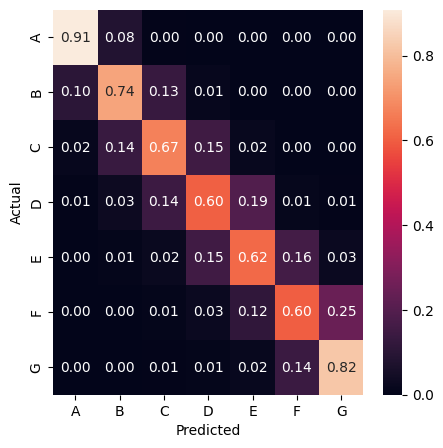

In [44]:
print("\nClassification Report for LightGBM")
print(classification_report(y_val, y_pred_val))
myFunc.confusion_matrix_normalized(
    y_val, y_pred_val, ["A", "B", "C", "D", "E", "F", "G"]
)

## XGB hyperparameters tuning

In [ ]:
def objective_xgb(trial):
    """Define the objective function"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 5, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            (
                "classifier",
                XGBClassifier(**params, objective="multi:softmax"),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    metric = f1_score(y_val, y_pred, average="macro")
    return metric

In [ ]:
study_xgb = optuna.create_study(direction="maximize")
func_xgb = lambda trial: objective_xgb(trial)
study_xgb.optimize(func_xgb, n_trials=30)

[I 2023-10-19 23:55:50,220] A new study created in memory with name: no-name-717bb5d7-b9eb-41d8-b783-3a9a66ed569d
[I 2023-10-19 23:56:39,226] Trial 0 finished with value: 0.3706581616137066 and parameters: {'max_depth': 6, 'learning_rate': 0.06860614383570973, 'n_estimators': 343, 'min_child_weight': 7, 'gamma': 1.3833432009346485e-08, 'subsample': 0.014188967760580677, 'colsample_bytree': 0.4747844807539235, 'reg_alpha': 2.5706627409419266e-06, 'reg_lambda': 0.20637989187985908}. Best is trial 0 with value: 0.3706581616137066.
[I 2023-10-19 23:57:28,576] Trial 1 finished with value: 0.46563931893023985 and parameters: {'max_depth': 6, 'learning_rate': 0.05328101472318289, 'n_estimators': 353, 'min_child_weight': 3, 'gamma': 0.6425438141073069, 'subsample': 0.26345886074140307, 'colsample_bytree': 0.11384906350551652, 'reg_alpha': 0.030956270914863086, 'reg_lambda': 0.7730253376638249}. Best is trial 1 with value: 0.46563931893023985.
[I 2023-10-19 23:59:14,727] Trial 2 finished with v

In [ ]:
print("Number of finished trials: {}".format(len(study_xgb.trials)))
print("Best trial:")
trial_xgb_best = study_xgb.best_trial

print("  Value: {}".format(trial_xgb_best.value))
print("  Params: ")

for key, value in trial_xgb_best.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 30
Best trial:
  Value: 0.7571598391580151
  Params: 
    max_depth: 8
    learning_rate: 0.12391342421549019
    n_estimators: 498
    min_child_weight: 6
    gamma: 0.0001949473311431891
    subsample: 0.9626103063644619
    colsample_bytree: 0.8515159162886619
    reg_alpha: 1.1701633325696607e-08
    reg_lambda: 0.0022813923589118934



Classification Report for XGB Classifier
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     43302
           1       0.87      0.84      0.85     66355
           2       0.86      0.82      0.84     65006
           3       0.77      0.78      0.77     32443
           4       0.66      0.68      0.67     13564
           5       0.55      0.71      0.62      4180
           6       0.50      0.87      0.63      1217

    accuracy                           0.83    226067
   macro avg       0.73      0.80      0.76    226067
weighted avg       0.83      0.83      0.83    226067



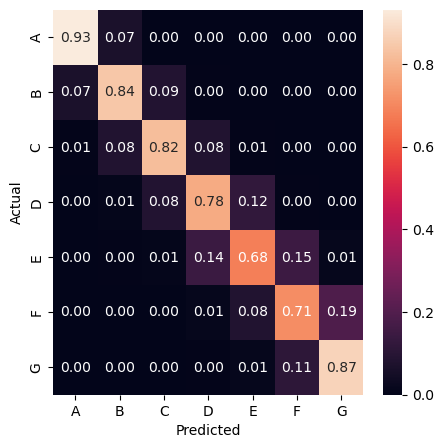

In [ ]:
params_best_xgb = trial_xgb_best.params

pipeline_xgb = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        (
            "classifier",
            XGBClassifier(**params_best_xgb),
        ),
    ]
)
model_tuned_xgb = pipeline_xgb.fit(X_train, y_train)
y_pred_v = model_tuned_xgb.predict(X_val)
print("\nClassification Report for XGB Classifier")
print(classification_report(y_val, y_pred_v))
myFunc.confusion_matrix_normalized(y_val, y_pred_v, ["A", "B", "C", "D", "E", "F", "G"])

# Best model predictions on test set


Classification Report for XGB Classifier
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     43303
           1       0.87      0.84      0.85     66356
           2       0.86      0.82      0.84     65005
           3       0.77      0.78      0.77     32442
           4       0.67      0.69      0.68     13564
           5       0.55      0.71      0.62      4180
           6       0.50      0.86      0.63      1217

    accuracy                           0.83    226067
   macro avg       0.73      0.80      0.76    226067
weighted avg       0.84      0.83      0.83    226067



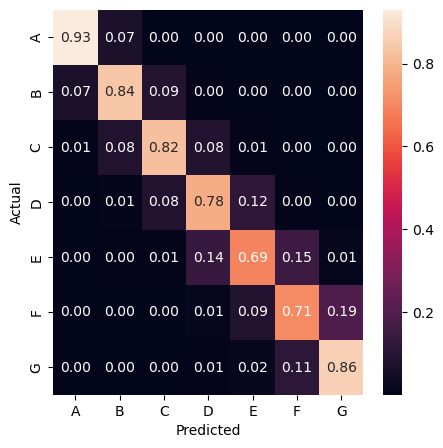

In [ ]:
y_pred_test = model_tuned_xgb.predict(X_test)
print("\nClassification Report for XGB Classifier")
print(classification_report(y_test, y_pred_test))
myFunc.confusion_matrix_normalized(
    y_test, y_pred_test, ["A", "B", "C", "D", "E", "F", "G"]
)

In [ ]:
# dump(pipeline_xgb, "grade_classifier.joblib")


['grade_classifier.joblib']

Most important features for this model were:
Most important features for this model were 
- total_rec_int	
- installment
- risk_score	
- term	
- bc_open_to_buy

We successfully improved the F1 score from 0.72 to 0.76 by fine-tuning the hyperparameters for the XGBoost Classifier. This represents the best possible model achievable using this approach.